## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [2]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [115]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [116]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    return([i for i in env.action_space(state)[0]])

In [117]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [118]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    z = np.random.random()
        
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        possible_actions = list(env.action_space(state)[0])
        action = possible_actions[random.randrange(len(possible_actions))]  #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [119]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
rewards_tracked = {
                    (('nan','nan','nan','nan','nan','nan','nan','nan','nan'),(3,5)):[],
                    ((2,'nan','nan',5,'nan','nan','nan','nan','nan'),(4,9)):[],
                    (('nan',4,'nan','nan',9,'nan','nan',6, 7),(0,3)): [],
                    ((3,'nan',2,'nan','nan','nan','nan','nan','nan'),(1,7)):[],
                    ((3, 1,'nan','nan','nan',4,'nan',8,'nan'),(3,9)):[]
                }

In [120]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [(('nan','nan','nan','nan','nan','nan','nan','nan','nan'),(3,5)),
                       (('nan','nan','nan',5,'nan','nan','nan','nan','nan'),(4,9)),
                       (('nan',4,'nan','nan',9,'nan','nan',6, 7),(0,3)),
                       ((3,'nan',2, 'nan','nan','nan','nan','nan','nan'),(1,7)),
                       ((3, 1, 'nan', 'nan', 'nan', 4, 'nan', 8, 'nan'),(3,9))]    #select any 5 Q-values
    for q_values in sample_q_values:
        state = Q_state(q_values[0])
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [121]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [122]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [123]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [124]:
#Defining parameters for the experiment

# EPISODES = 50
EPISODES = 500000
STEPS = 4
#STEPS = 9
LR = 0.01                   #learning rate
GAMMA = 0.91


threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
# threshold = 1
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
# policy_threshold = 3

### Q-update loop ---write your code here

In [125]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()      #creating an instance of the class
    #this initialises the state back to some initial value which is required for every new episode
    #this also initialises all parameters like m,p,K, etc.
    
    initial_state = env.state    #for the purpose of tracking reward
    current_state = env.state
    add_to_dict(current_state)
    time_step = 0
    reward = None
    terminal = False
    total_reward = 0
        
    while (time_step < STEPS and terminal != True):    #the episode will run only for a few steps and not infinitely
        curr_action = epsilon_greedy(current_state, episode)
        next_state, reward, terminal = env.step(current_state, curr_action)
        add_to_dict(next_state)

        # UPDATE RULE
        max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
        Q_dict[Q_state(current_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) - Q_dict[Q_state(current_state)][curr_action] )        
        current_state = next_state       #state(t) became state(t-1)
        total_reward += reward        
        time_step += 1

    
    #TRACKING REWARDS
    if Q_state(initial_state) in rewards_tracked:     #storing rewards
        rewards_tracked[Q_state(initial_state)].append(total_reward)
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the (n-1)th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every (n)th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #decides when to save the Q-dict
        save_obj(Q_dict,'Policy')
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print(episode)

499999


#### Check the Q-dictionary

In [132]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.903935006555376,
              (0, 3): -0.9204144066987124,
              (0, 5): -0.8097888054464395,
              (0, 7): -1.4202967918592897,
              (0, 9): -1.5245446848365345,
              (1, 1): -0.9186478199776711,
              (1, 3): -0.8721825119324255,
              (1, 5): -0.9083183656371289,
              (1, 7): -1.245891183617041,
              (1, 9): -1.6494173413010467,
              (2, 1): -0.7495890085616839,
              (2, 3): -0.8906127314878308,
              (2, 5): -0.8517559467748087,
              (2, 7): -1.4659004360433472,
              (2, 9): -1.272328935953889,
              (3, 1): -0.8485280005349837,
              (3, 3): -0.9023645422037294,
              (3, 5): -0.8741902812197289,
              (3, 7): -0.9785824857351815,
              (3, 9): -0.9650788750520966,
              (4, 1): -0.8935078613438366,
              (4, 3): -0.8298543068029015,
              (4, 

In [133]:
len(Q_dict)

1057789

In [134]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['5-x-4-x-2-x-x-9-x']

{(1, 1): -0.01,
 (1, 3): 0,
 (1, 7): 0,
 (3, 1): 0,
 (3, 3): 0,
 (3, 7): 0,
 (5, 1): 0,
 (5, 3): 0,
 (5, 7): 0,
 (6, 1): 0,
 (6, 3): -0.01,
 (6, 7): 0,
 (8, 1): 0,
 (8, 3): 0,
 (8, 7): 0}

#### Check the states tracked for Q-values convergence
(non-evaluative)

[]

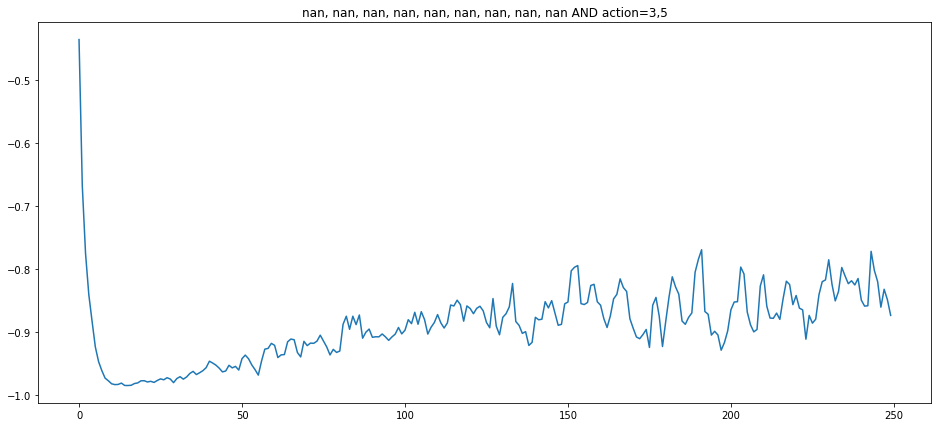

In [147]:
# Write the code for plotting the graphs for state-action pairs tracked
with open('States_tracked.pkl', 'rb') as handle:
   States_track = pickle.load(handle)

xaxis = np.asarray(range(0, 250))
plt.figure(0, figsize=(16,7))
plt.title('nan, nan, nan, nan, nan, nan, nan, nan, nan AND action=3,5')
plt.plot(xaxis,np.asarray(States_track[Q_state(['nan','nan','nan','nan','nan','nan','nan','nan','nan'])][(3,5)]))
plt.plot()

In [148]:
print("Size: "+ str(len(States_track)))
print("Keys: "+ str(States_track.keys()))
print(States_track)

Size: 5
Keys: dict_keys(['x-x-x-x-x-x-x-x-x', 'x-x-x-5-x-x-x-x-x', 'x-4-x-x-9-x-x-6-7', '3-x-2-x-x-x-x-x-x', '3-1-x-x-x-4-x-8-x'])
defaultdict(<class 'dict'>, {'x-x-x-x-x-x-x-x-x': {(3, 5): [-0.4360948095476122, -0.66824822196115, -0.7760771771487768, -0.8412481108944863, -0.8834778095638468, -0.924256761740149, -0.9476758539084176, -0.9619847311047345, -0.9738619868936937, -0.9780689216887243, -0.9828494787591673, -0.9841336533779398, -0.9838661349021793, -0.9817193218767176, -0.9855021818658825, -0.9855554775583295, -0.9852155133787945, -0.9824331456715788, -0.9814580765895361, -0.9780907123165, -0.9779476513365275, -0.9799481030552849, -0.9788824930554949, -0.9806672890141823, -0.9775783673296676, -0.9750339645215458, -0.976507728397127, -0.9731548373097131, -0.9752945604892187, -0.9810226790822799, -0.9745342602025446, -0.9715703901119264, -0.9754690402024052, -0.972025896544721, -0.9663843966048368, -0.963124220607371, -0.9681413327794015, -0.9652740650901062, -0.9619754185461455,

### Epsilon - decay check

In [149]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

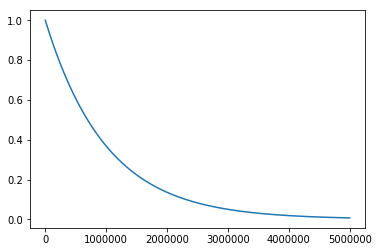

In [150]:
plt.plot(time, epsilon)
plt.show()